# Audio Recognition Using Siamese Network

In the last tutorial, we saw how to use the siamese networks to recognize a face. Now we will see how to use the siamese networks to recognize the audio. We will train our network to differentiate between a dog's and a cat's sound. The dataset of cats and dogs audio can be downloaded from here https://www.kaggle.com/mmoreaux/audio-cats-and-dogs#cats_dogs.zip

Once we have downloaded the data, we fragment our data into three folders Dogs, Sub_dogs, and Cats. In Dogs and Sub_dogs, we place the dog's barking audio and in Cats folder, we place the cat's audio. The objective of our network is to recognize whether the audio is the dog's barking sound or some different sound. As we know for a Siamese network, we need to feed input as a pair, we select an audio from Dogs and Sub_dogs folder and mark it as a genuine pair and we select an audio from Dogs and Cats folder and mark it as an imposite pair. That is, (dogs, subdogs) is genuine pair and (dogs, cats) is imposite pair.

Now we will step by step how to train our siamese network to recognize whether the audio is the dog's barking sound or some different sound. First, We will load all the necessary libraries:

In [121]:

# In[1]:
from preprocessing import cv_preprocessing

print("sad imports")

#basic imports
import glob
#import IPython
from random import randint
print("sad imports")

#data processing
import numpy as np
print("sad imports")
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, auc, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

#modelling
from sklearn.model_selection import train_test_split
print("sad imports")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras import backend as K
print("sad imports")

from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Flatten
from keras.models import Model
print("sad imports")

from keras.optimizers import RMSprop
from load_data import load_data


sad imports
sad imports
sad imports
sad imports
sad imports
sad imports


Before going ahead, We load and listen to the audio clips,

So, how can we feed this raw audio to our network? How can we extract meaningful features from the raw audio? As we know neural networks accept only vectorized input, we need to convert our audio to a feature vector. How can we do that? Well, there are several mechanisms through which we can generate embeddings for the audio. One such popular mechanism is Mel-Frequency Cepstral Coefficients (MFCC). 

We use MFCC for vectorizing our audio. MFCC converts the short-term power spectrum of an audio using a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. To learn more about MFCC check this nice tutorial (http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

We will use MFCC function from librosa library for generating the audio embeddings. So, we define a function called audio2vector which return the audio embeddings given the audio:

In [122]:

def print_results(y_true, y_pred, name=''):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    avs = average_precision_score(y_true, y_pred)
    auc_score = auc(recall, precision)

    print('/n/n', name)

    plt.plot(recall, precision)
    plt.title("recall precision curve")

    plt.show()

    plt.hist(y_pred)
    plt.title("prediction histogram")
    plt.show()

    print(f"pr_auc = {auc_score}")

    print(f"average_precision_score = {avs}")

    print(f"holdout i = , roc_auc = {roc_auc_score(y_true, y_pred)}")



We will load one audio file and see the embeddings

Now that we have understood how to generate audio embeddings, we need to create the data for our Siamese network. As we know, Siamese network accepts the data in a pair, we define the function for getting our data. We will create the genuine pair as (Dogs, Sub_dogs) and assign label as 1 and imposite pair as (Dogs, Cats) and assign label as 0.

In [123]:
def get_training_data():
    
    pairs = []
    labels = []
    
    Dogs = glob.glob('data/audio/Dogs/*.wav')
    Sub_dogs = glob.glob('data/audio/Sub_dogs/*.wav')
    Cats = glob.glob('data/audio/Cats/*.wav')
    
    
    np.random.shuffle(Sub_dogs)
    np.random.shuffle(Cats)
    
    for i in range(min(len(Cats),len(Sub_dogs))):
        #imposite pair
        if (i % 2) == 0:
            pairs.append([audio2vector(Dogs[randint(0,3)]),audio2vector(Cats[i])])
            labels.append(0)
            
        #genuine pair
        else:
            pairs.append([audio2vector(Dogs[randint(0,3)]),audio2vector(Sub_dogs[i])])
            labels.append(1)
            
            
    return np.array(pairs), np.array(labels)

In [146]:

df_preprocessed, features, target_feature = load_data()
df_preprocessed = df_preprocessed.dropna(subset=['target_binary_intrusion'], how='any')

X_train, X_test, y_train, y_test = train_test_split(df_preprocessed[features], df_preprocessed['target_binary_intrusion'],
                                      test_size=0.15, stratify=df_preprocessed['target_binary_intrusion'])
X_train, X_test = cv_preprocessing(X_train, X_test)


In [148]:
X_train['binary_intrusion'].unique()

array([ 1.70970083, -0.58489765])

In [152]:
X_train['label'] = y_train
print(X_train[X_train['label']==1].shape)
print(X_train[X_train['label']==0].shape)

(61, 86)
(197, 86)


In [154]:
(197+61)/2

129.0

In [167]:
Sub_dogs = X_train[X_train['label']==0].iloc[129:].drop('label', axis=1)

In [168]:
Cats = X_train[X_train['label']==1].drop('label', axis=1)

In [169]:
pairs = []
labels = []
    
Dogs = X_train[X_train['label']==0].iloc[:129].drop('label', axis=1)
Sub_dogs = X_train[X_train['label']==0].iloc[129:].drop('label', axis=1)
Cats = X_train[X_train['label']==1].drop('label', axis=1)    
    

In [170]:
    
for i in range(len(Cats)+len(Sub_dogs)):
        #imposite pair
    if i == len(Dogs):
        break
    elif (i < len(Cats)):
        pairs.append([Dogs.iloc[i],Cats.iloc[i]])
        labels.append(0)
            
        #genuine pair
    else:
        pairs.append([Dogs.iloc[i],Sub_dogs.iloc[i-len(Cats)]])
        labels.append(1)
            


In [171]:
X, Y = np.array(pairs), np.array(labels)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

Now that we have successfully generated our data, we build our Siamese network. We define our base network which is used for feature extraction, we use three dense layers with dropout layer in between.

In [172]:
def build_base_network(input_shape):
    input_x = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input_x)
    x = Dropout(0.1)(x)
    return Model(input_x, x)

Next, we feed the audio pair to the base network, which will return the features:

In [173]:
input_dim = X.shape[2:]

audio_a = Input(shape=input_dim)
audio_b = Input(shape=input_dim)

These feat_vecs_a and feat_vecs_b are the feature vectors of our audio pair. Next, we feed this feature vectors to the energy function to compute a distance between them, we use Euclidean distance as our energy function:

In [174]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [175]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))





Next, we set the epoch length to 13 and we use RMS prop for optimization.

4/4 [==============================] - 0s 1ms/step - loss: 33.7988
/n/n 


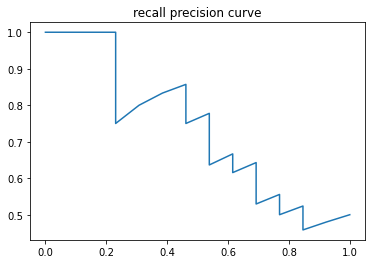

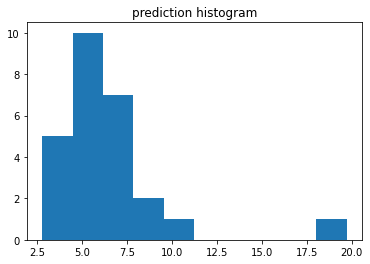

pr_auc = 0.7303834438562944
average_precision_score = 0.7413186813186812
holdout i = , roc_auc = 0.6568047337278107
4/4 [==============================] - 0s 1ms/step - loss: 48.1413
/n/n 


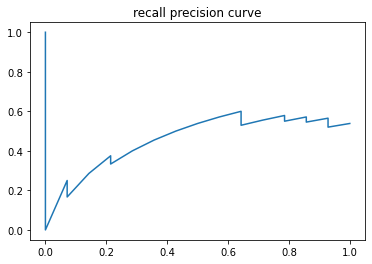

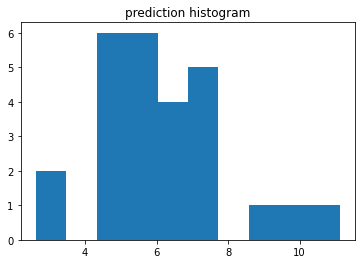

pr_auc = 0.4548332853995267
average_precision_score = 0.484625733951494
holdout i = , roc_auc = 0.4285714285714286
4/4 [==============================] - 0s 1ms/step - loss: 38.9085
/n/n 


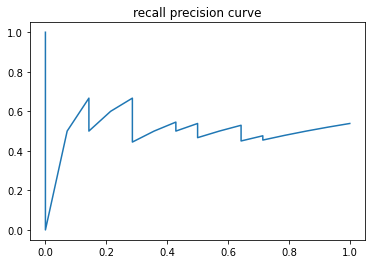

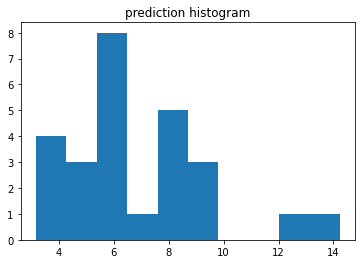

pr_auc = 0.49905326790693977
average_precision_score = 0.5399695761551808
holdout i = , roc_auc = 0.42261904761904756
4/4 [==============================] - 0s 1ms/step - loss: 32.7522
/n/n 


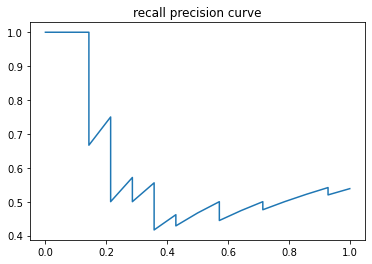

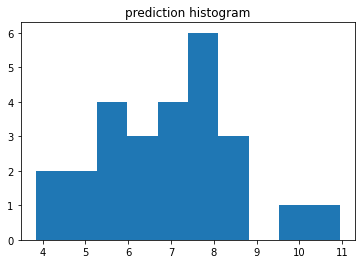

pr_auc = 0.5819775175516431
average_precision_score = 0.5986243429484684
holdout i = , roc_auc = 0.4285714285714286
4/4 [==============================] - 0s 833us/step - loss: 44.8888
/n/n 


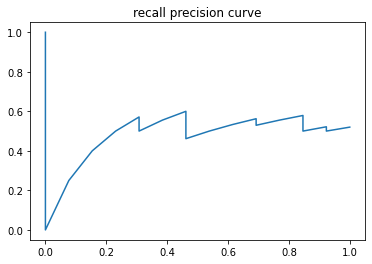

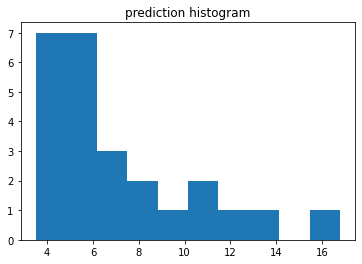

pr_auc = 0.47824823790067844
average_precision_score = 0.511466116517604
holdout i = , roc_auc = 0.4871794871794872


In [176]:
cv = StratifiedKFold(5)

for train, test in cv.split(X, Y):
    
    x_train, y_train = X[train], Y[train]
    x_test, y_test = X[test], Y[test]
    epochs = 13
    rms = RMSprop()

    base_network = build_base_network(input_dim)
    audio_1 = x_train[:, 0]
    audio_2 = x_train[:, 1]
    feat_vecs_a = base_network(audio_a)
    feat_vecs_b = base_network(audio_b)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
    model = Model(inputs = [audio_a, audio_b], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=rms)



    model.fit([audio_1, audio_2], y_train.astype(float))

    print_results(y_test, model.predict([x_test[:,0], x_test[:,1]]))